## Methods and Results
Note: Graphs will look much more professional and organized for final report.
### Importing Libraries and Reading in Datafiles
The first thing that was done was import important Python libraries that were going to be used throughout the analysis. These libraries included NumPy, Pandas, Matplotlib, and datetime.

In [1]:
import numpy as np                   # functions for data analysis 
import pandas as pd                  # functions for data frames
from matplotlib import pyplot as plt # functions for plotting
import datetime
import glob

Next, the datafiles that were used for the analysis were downloaded. This included the dataset from 2000 to 2020 for the Nantucket, MA Station (datum was Mean Sea Level (MSL)) and the 2020 dataset for the NOAA Local Climatology Station at Nantucket Airport, MA. These files were downloaded as CSV files and saved into the working directory for the project. Information regarding the minor or nuisance flood thresholds specific to the Massachusetts Coast were gathered from the NOAA Inundation History site where a minor flood threshold for Nantucket is given as about 3.25 feet above MSL. The Mean High High Water (MHHW) datum was also recorded. Sea Level Trend data was also gathered from the NOAA Sea Level Trend Site where a 3.79 mm/year was determined as the relative sea level trend for the Nantucket station.  Once this data were gathered and organized, the constants were defined to be used throughout the code. These constants included the filenames, locations of the stations used, minor flood threshold, MHHW datum, and sea level trend.

In [2]:
path = r'C:\Users\ldwyr\OneDrive\Desktop\ESCI 895\Project\WL_CSV'
filenames = glob.glob(path + "/*.csv")
wind_filename = 'wind.csv'
df_list = []
location = 'Nantucket, MA'
datum = 'Mean Sea Level'
threshold = 3.25
mhhw = 1.8
slr = 3.79

Since the NOAA Water Level Data could only be downloaded for one year at a time, a for loop was created to read in each of the water level files with defining nan values as “NaN”, "-", “9999”, and “-9999” and saving all of the read in files into a list. These nan values were then filled using the "Predicted (ft)" column. The dataframes were saved by concating the datafrma list into a single dataframe (df_wl) . The index was then set to be both the Date and the Time columns. The other columns were dropped except for the verified water level data and the NOAA predicted water level data. 

In [3]:
df_list = []
for filename in filenames:
    df = pd.read_csv(filename, delimiter=",", comment='%', header=0, na_values=(9999, -9999, "NaN",'-'))
    df = df[['Time (LST)', 'Predicted (ft)', 'Verified (ft)', 'Date']]
    # This loc statement isn't working but will be fixed for final results
    df.loc[df['Verified (ft)'] == 'NaN', 'Verified (ft)'] = df.loc[df['Verified (ft)'] == 'NaN', 'Predicted (ft)'].values
    df_list.append(df)
df_wl = pd.concat(df_list)
df_wl['datetime'] = pd.to_datetime(df_wl['Date'].astype(str)+' '+df_wl['Time (LST)'].astype(str))
df_wl.set_index('datetime', inplace = True)
df_wl = df_wl[['Predicted (ft)', 'Verified (ft)']]

Two new dataframes were created, one for the year 2000 and one for the year 2020. This was done to compare the water level data from the beginning of the analysis record to the end. A figure showing two timeseries plot, one for each year with the threshold plotted as a horizontal line on both graphs.

In [5]:
start_dates = [datetime.datetime(2000, 1, 1), datetime.datetime(2020, 1, 1)]
end_dates = [datetime.datetime(2000, 12, 31), datetime.datetime(2020, 12, 31)]
df_2000 = df_wl[start_dates[0]:end_dates[0]] 
df_2020 = df_wl[start_dates[1]:end_dates[1]]

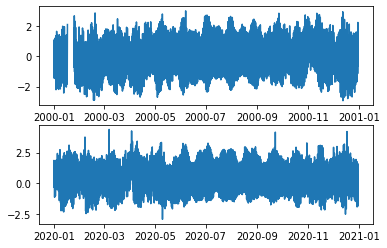

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)
ax1.plot(df_2000['Verified (ft)'])
ax2.plot(df_2020['Verified (ft)'])
# will plot threshold line but trying to figure out how to do this on both graphs

### Determining Flood Hours
A similar analysis that was performed by the NOAA technical report, Sea Level Rise and Nuisance Flood Frequency Changes around the United States, where the dates, times, and water levels that were at or above the defined minor flooding threshold were located and extracted from df_wl and moved to a new dataframe named df_years.  These times were found by using True/False statements where any water level that was at or above the threshold value defined was determined as True and all other values were determined as False. These True/False values were saved in the df_wl in a column titled "Boolean". The number of hours per year where high tide flooding occurred was calculated by summing the "Boolean" column and grouped by years.

In [11]:
df_wl['Boolean'] = np.where(df_wl['Verified (ft)'] >= threshold, True, False)
df_wl['day'] = df_wl.index.day
df_wl['month'] = df_wl.index.month
df_wl['year'] = df_wl.index.year
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
         2019, 2020]
df_years = pd.DataFrame(years, columns = ['Year'])
df_years.set_index('Year', inplace = True)
df_years['flood_hours'] = df_wl[['Boolean', 'year']].groupby('year').sum()
df_years['log(flood)'] = np.log10(df_years['flood_hours'])
df_years.iloc[0, 1] = np.nan

C:\Users\ldwyr\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Distribution of Flood Hours
A figure was made showing two histograms, one of the distribution of the flood hours and one of the log transformed flood hours. The average flood hours were plotted as vertical lines on each graph.

(array([1., 0., 0., 7., 3., 2., 3., 2., 1., 1.]),
 array([0.47712125, 0.62131694, 0.76551262, 0.90970831, 1.05390399,
        1.19809967, 1.34229536, 1.48649104, 1.63068672, 1.77488241,
        1.91907809]),
 <BarContainer object of 10 artists>)

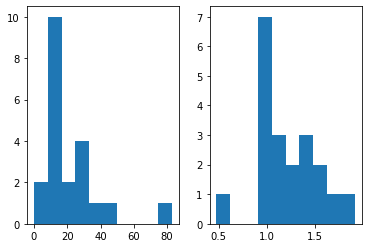

In [13]:
avg = np.mean(df_years['flood_hours'])
avg_log = np.mean(df_years['log(flood)'])
fig, (ax4, ax5) = plt.subplots(nrows = 1, ncols = 2)
ax4.hist(df_years['flood_hours'])
ax5.hist(df_years['log(flood)'])

#### Interpolation of the Flood Hours
A linear interpolation of the flood hours over time was performed and plotted against the flood hours measured. The interpolated line was labeled with the equation and the correlation coefficient to determine the extent to which the data follows a linear trend.

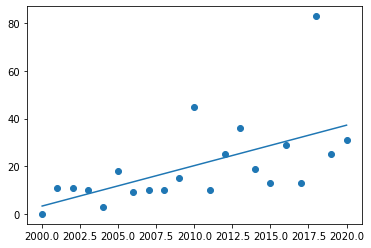

In [34]:
# Since the above histogram shows that the log-transform of the data shows a more normal distribution, I might try to do 
# this analysis with a power interpolation. However, here is the analysis with linear interpolation.
df_years['year_interp'] = years
slope, intercept = np.polyfit(df_years['year_interp'], df_years['flood_hours'], 1)
df_years['interp'] = df_years['year_interp']*slope+intercept
fig, ax6 = plt.subplots()
ax6.scatter(df_years['year_interp'], df_years['flood_hours'])
line = ax6.plot(df_years['interp'], label = 'y = 1.697x - 3391', color = 'r')


### Determining Influences of Flood Hours
#### Seasonality
The NOAA technical report analyzed whether seasonality influenced the amount of high tide flooding that occurred throughout the year. This analysis helps communities plan for flooding during different times of the year. For example, if the fall season has more high tide flooding events occur than in the spring, communities can implement more protection measures during this time of year and less in the spring. The number of flood hours per month was determined similarly to the flood hours per year, except with this analysis, the sum of the True was grouped by the month instead of the year.

<BarContainer object of 12 artists>

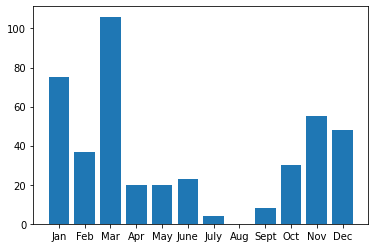

In [31]:
dfmonth = df_wl[['Boolean', 'month']].groupby('month').sum() 
dfmonth['Month Name'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug',
                        'Sept', 'Oct', 'Nov', 'Dec']

fig, ax7 = plt.subplots()
ax7.bar(dfmonth['Month Name'], dfmonth['Boolean'])

In [37]:
dfmonth['jdaymid'] = df_wl['day'].groupby(df_wl['month']).median()
centroid = (sum(dfmonth['Boolean']*dfmonth['jdaymid']))/(sum(dfmonth['Boolean']))
print(centroid)

15.788732394366198


#### Wind
Wind data from NOAA's Local Climatology station in Nantucket was downloaded for the year, 2020. It was read in using the DATE column as the index. The NaN values were defined as '9999', '-9999', 'NaN', and '-' and were filled using the forward fill method because there were not many data gaps. All of the columns were dropped except for the Hourly Wind Direction and the Hourly Wind Speed. The water level data for the year 2020 was analyzed to determine what times the water level data was at or above the threshold. Week-long periods surrounding the time that the water-level was at or above the threshold were saved into a new dataframe, dfevent. A for loop was then used to create a figure of the weeklong periods showing water-level data on the left y-axis and windspeed data on the right y-axis. The figure was annoted to show the windspeed and direction at the times where the water level was at or above the flood threshold.

C:\Users\ldwyr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (21,27,28,29,31,38,42,43,59,60,63,115,118,120) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-22-cf909f2674ca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['Boolean'] = np.where(df_2020['Verified (ft)'] >= threshold, True, False)


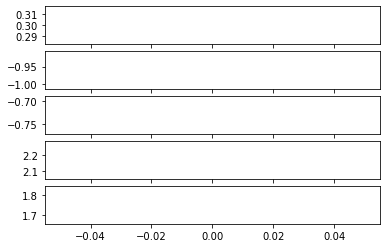

In [22]:
df_wind = pd.read_csv(wind_filename, delimiter=",", comment='%', header=0, parse_dates=['DATE'], index_col=['DATE'], 
                     na_values=(9999, -9999, "NaN",'-'))
df_wind = df_wind[['HourlyWindDirection', 'HourlyWindSpeed']]
df_wind = df_wind.fillna(method = 'ffill')

df_2020['Boolean'] = np.where(df_2020['Verified (ft)'] >= threshold, True, False)
# These are weeklong events that had one or more times where the water level went above the threshold
wind_start = [datetime.datetime(2020, 4, 1), datetime.datetime(2020, 5, 31), 
              datetime.datetime(2020, 6, 30), datetime.datetime(2020, 9, 19),
              datetime.datetime(2020, 12, 14)]
wind_end = [datetime.datetime(2020, 4, 7), datetime.datetime(2020, 6, 6),
            datetime.datetime(2020, 7, 6), datetime.datetime(2020, 9, 26),
            datetime.datetime(2020, 12, 21)]
dfevent = pd.DataFrame(wind_start, columns = ['start date'])
dfevent['end date'] = wind_end
# This for loop is currently not working. For the final results, this figure should display 5 timeseries plots showing the 
# different weeklong events of water level on one y-axis and windspeed on the second-y-axis. The times where the water level
# went above the threshold will be annotated with arrows that are labeled with the windspeed and direction
fig, ax9 = plt.subplots(nrows = 5, ncols = 1)
for i, v in dfevent.iterrows():
    ax9[i].plot(df_2020.loc[dfevent.iloc[i,0], 'Verified (ft)'], color = 'purple')

### Sea Level Rise Analysis
#### Determining Future Flood Hours using NOAA's Predicted SLR Trend
NOAA has determined SLR trend data for various tidal stations, including the Nantucket station. To determine the number of flood hours in future decades, the df_2000 Verified column was used  since most SLR analyses use the year 2000 as the baseline. New columns were added to the df_2000 dataframe and interpolated water level data using the SLR trend and multiplying this slope by the number of years each decade is from the baseline year, 2000, and was added to the water levels from the df_2000. A similar analysis as before was performed to determine the number of hours for each year that the water level was at or above the threshold. These hours were saved to a new dataframe, df_slr and plotted to show the linear trend of flood hours over the next century.

In [28]:
# The goal for this analysis is to create new columns in the df_2000 dataframe where using the year 2000's water level water
# data as the y-intercept and then multiplying the slr trend (slope) by the number of years since 2000 up to 2100. This will
# be done using decades. Currently trying to figure out the for-loop.The end result will be a graph showing the estimated
# number of hours at each year based on the increase in water levels from slr.
decades = [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
#for i in enumerate(decades):
    #df_2000[i] = df_2000['Verified (ft)']+slr*(decades[i]-2000)

TypeError: list indices must be integers or slices, not tuple

#### Determining Future Flood Hours Using Trendline from 2000-2020
The trendline that was created for the 2000-2020 data was used to determine the number of flood hours per year in future decades to compare to the NOAA SLR trend. 

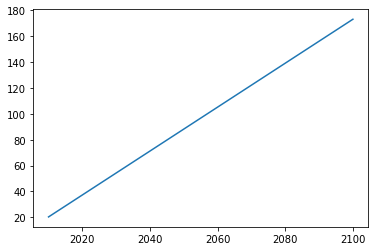

In [35]:
df_interp = pd.DataFrame(decades, columns = ['Years'])
df_interp['flood_interp'] = slope*df_interp['Years']+intercept
fig, ax10 = plt.subplots()
ax10.plot(df_interp['Years'], df_interp['flood_interp'])